<a href="https://colab.research.google.com/github/abhayraghuwanshi/Skill-Set-Classification/blob/main/multilabel_skillset_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = "/content/drive/My Drive/dataset/"

In [ ]:
raw_occupation_data = pd.read_excel(os.path.join(path, "Occupation Data.xlsx"))
raw_skills = pd.read_excel(os.path.join(path, "Skills.xlsx"))
raw_work_styles = pd.read_excel(os.path.join(path, "Work Styles.xlsx"))

In [ ]:
#work style preprocessing all the scale Id are IM
work_style_cols = ["O*NET-SOC Code", "Title", "Element Name","Scale ID", "Data Value"]
work_styles = raw_work_styles.loc[:, work_style_cols ].loc[raw_work_styles["Scale ID"]=="IM"]
work_styles = work_styles.pivot(index='O*NET-SOC Code', columns="Element Name", values='Data Value')
work_styles.head()

Element Name,Achievement/Effort,Adaptability/Flexibility,Analytical Thinking,Attention to Detail,Concern for Others,Cooperation,Dependability,Independence,Initiative,Innovation,Integrity,Leadership,Persistence,Self Control,Social Orientation,Stress Tolerance
O*NET-SOC Code,,,,,,,,,,,,,,,,
11-1011.00,4.55,4.20,4.45,4.49,4.22,4.44,4.65,4.54,4.75,4.27,4.80,4.97,4.43,4.52,3.67,4.75
11-1011.03,4.19,4.23,4.31,4.12,3.48,4.32,4.23,4.27,4.60,4.38,4.58,4.64,4.31,4.00,3.35,4.08
11-1021.00,4.18,4.09,4.03,4.25,4.06,4.16,4.54,3.99,4.35,3.65,4.30,4.59,4.04,4.31,3.57,4.33
11-2011.00,4.10,4.42,3.88,4.48,3.81,4.51,4.51,4.04,4.56,3.99,4.17,4.03,4.32,4.18,3.70,4.35
11-2021.00,4.32,4.31,4.00,4.32,3.37,4.08,4.35,3.88,4.53,4.15,4.17,4.37,4.23,3.87,3.80,4.01


In [ ]:
#skills
skills_cols = ["O*NET-SOC Code", "Title", "Element Name","Scale ID", "Data Value"]
skills = raw_skills.loc[:, skills_cols].loc[raw_skills["Scale ID"]=="IM"]
skills = skills.pivot(index='O*NET-SOC Code', columns="Element Name", values='Data Value')
skills.head()

Element Name,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,Learning Strategies,Management of Financial Resources,Management of Material Resources,Management of Personnel Resources,Mathematics,Monitoring,Negotiation,Operation Monitoring,Operation and Control,Operations Analysis,Persuasion,Programming,Quality Control Analysis,Reading Comprehension,Repairing,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
O*NET-SOC Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11-1011.00,4.00,4.12,4.38,4.25,4.38,1.0,1.12,1.0,3.12,4.50,3.12,4.12,3.88,4.25,3.25,4.12,4.12,1.88,1.75,3.12,4.12,1.62,1.75,4.12,1.0,1.88,3.12,4.25,4.38,4.12,4.12,1.75,4.00,1.00,4.00
11-1011.03,3.50,3.88,4.00,3.62,4.00,1.0,1.12,1.0,3.25,3.75,3.38,2.62,2.38,3.38,2.75,3.62,2.88,2.25,1.62,2.62,3.62,1.62,2.25,4.00,1.0,1.75,3.25,3.75,4.00,3.62,3.62,1.62,3.38,1.12,3.88
11-1021.00,3.50,4.00,3.50,4.00,3.88,1.0,1.00,1.0,3.12,3.50,3.00,3.12,3.25,3.50,2.38,4.00,3.62,2.75,2.00,2.75,3.38,1.50,2.38,3.88,1.0,1.88,3.25,4.00,4.00,3.00,3.00,1.88,3.75,2.00,3.25
11-2011.00,3.25,4.12,3.50,3.50,4.00,1.0,1.12,1.0,2.88,3.75,3.00,2.75,2.62,3.12,3.00,3.25,3.12,1.62,1.00,2.75,3.38,1.75,1.62,3.75,1.0,1.62,3.12,4.00,4.00,3.12,3.12,1.75,3.50,1.00,3.75
11-2021.00,3.88,3.88,3.62,3.50,3.88,1.0,1.00,1.0,3.00,3.75,3.12,2.88,2.62,3.38,2.75,3.75,3.62,1.75,1.00,3.38,3.75,1.88,1.88,3.88,1.0,1.75,3.12,3.88,3.88,3.25,3.50,1.75,3.50,1.00,3.25


In [ ]:
dataset = skills.merge(work_styles, on="O*NET-SOC Code")
dataset = raw_occupation_data.merge(dataset, on="O*NET-SOC Code")
dataset.head()

,O*NET-SOC Code,Title,Description,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,Learning Strategies,Management of Financial Resources,Management of Material Resources,Management of Personnel Resources,Mathematics,Monitoring,Negotiation,Operation Monitoring,Operation and Control,Operations Analysis,Persuasion,Programming,Quality Control Analysis,Reading Comprehension,Repairing,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing,Achievement/Effort,Adaptability/Flexibility,Analytical Thinking,Attention to Detail,Concern for Others,Cooperation,Dependability,Independence,Initiative,Innovation,Integrity,Leadership,Persistence,Self Control,Social Orientation,Stress Tolerance
0,11-1011.00,Chief Executives,Determine and formulate policies and provide o...,4.00,4.12,4.38,4.25,4.38,1.0,1.12,1.0,3.12,4.50,3.12,4.12,3.88,4.25,3.25,4.12,4.12,1.88,1.75,3.12,4.12,1.62,1.75,4.12,1.0,1.88,3.12,4.25,4.38,4.12,4.12,1.75,4.00,1.00,4.00,4.55,4.20,4.45,4.49,4.22,4.44,4.65,4.54,4.75,4.27,4.80,4.97,4.43,4.52,3.67,4.75
1,11-1011.03,Chief Sustainability Officers,"Communicate and coordinate with management, sh...",3.50,3.88,4.00,3.62,4.00,1.0,1.12,1.0,3.25,3.75,3.38,2.62,2.38,3.38,2.75,3.62,2.88,2.25,1.62,2.62,3.62,1.62,2.25,4.00,1.0,1.75,3.25,3.75,4.00,3.62,3.62,1.62,3.38,1.12,3.88,4.19,4.23,4.31,4.12,3.48,4.32,4.23,4.27,4.60,4.38,4.58,4.64,4.31,4.00,3.35,4.08
2,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",3.50,4.00,3.50,4.00,3.88,1.0,1.00,1.0,3.12,3.50,3.00,3.12,3.25,3.50,2.38,4.00,3.62,2.75,2.00,2.75,3.38,1.50,2.38,3.88,1.0,1.88,3.25,4.00,4.00,3.00,3.00,1.88,3.75,2.00,3.25,4.18,4.09,4.03,4.25,4.06,4.16,4.54,3.99,4.35,3.65,4.30,4.59,4.04,4.31,3.57,4.33
3,11-2011.00,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...",3.25,4.12,3.50,3.50,4.00,1.0,1.12,1.0,2.88,3.75,3.00,2.75,2.62,3.12,3.00,3.25,3.12,1.62,1.00,2.75,3.38,1.75,1.62,3.75,1.0,1.62,3.12,4.00,4.00,3.12,3.12,1.75,3.50,1.00,3.75,4.10,4.42,3.88,4.48,3.81,4.51,4.51,4.04,4.56,3.99,4.17,4.03,4.32,4.18,3.70,4.35
4,11-2021.00,Marketing Managers,"Plan, direct, or coordinate marketing policies...",3.88,3.88,3.62,3.50,3.88,1.0,1.00,1.0,3.00,3.75,3.12,2.88,2.62,3.38,2.75,3.75,3.62,1.75,1.00,3.38,3.75,1.88,1.88,3.88,1.0,1.75,3.12,3.88,3.88,3.25,3.50,1.75,3.50,1.00,3.25,4.32,4.31,4.00,4.32,3.37,4.08,4.35,3.88,4.53,4.15,4.17,4.37,4.23,3.87,3.80,4.01


<h1>Data Visualizations</h1>
Plotting the importance of the features for the Cheif Excutive Title 

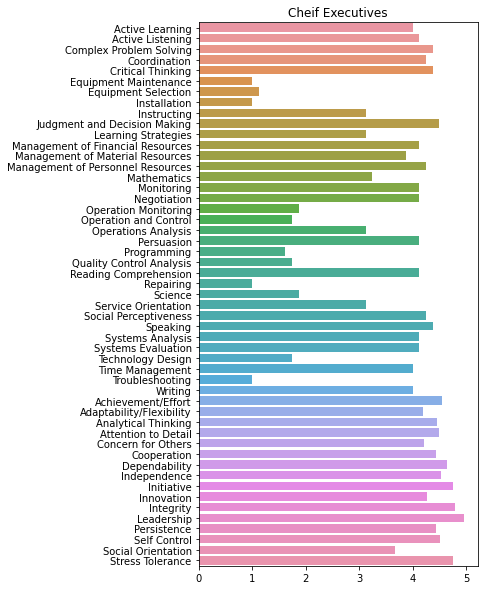

In [ ]:
features = list(dataset.loc[:, "Active Learning":"Stress Tolerance"].columns)
plt.figure(figsize=(5, 10))
plt.title("Cheif Executives")
sns.barplot(y=features, x=dataset.loc[0, "Active Learning":"Stress Tolerance"].values)

<h1>PREPROCESSING</h1>
The text has to be vectorized so that we can feed it into our model. Keras comes with several text preprocessing classes that we can use for that.

The labels need encoded as well, so that the 51 labels will be represented as 51 binary values in an array. This can be done with the MultiLabelBinarizer from the sklearn library.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

vocab_size = 20000
sequence_length = 100
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(dataset["Description"])
sequences = tokenizer.texts_to_sequences(dataset["Description"])
X = pad_sequences(sequences, maxlen=sequence_length)

Here we are selecting the top 25 labels features having the largest values in each rows and adding them to the to the new columns Tag

In [ ]:
y = dataset.loc[:, "Active Learning":"Stress Tolerance"]

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit([list(y.columns)])
total_labels = len(mlb.classes_)
def get_label(data):
    data = data.sort_values(ascending=False)
    return np.array(data[1:25].index)
y["Tags"] = y.apply(lambda row : get_label(row), axis=1)
y_labels = mlb.transform(y["Tags"])

In [ ]:
output = dataset.loc[:, "O*NET-SOC Code": "Description"]
output["tags"] = y["Tags"]
output.to_csv("sample_submission.csv")

<h2>Imbalance Classes</h2>
Some tags occur more often than others, thus the classes are not well balanced. The imbalanced class problem can be addressed by applying class weights, thus weighting less frequent tags higher than very frequent tags.

In [ ]:
tags_weight = pd.DataFrame(y_labels).apply(lambda x:sum(x))
most_tags = pd.DataFrame(tags_weight.values, index=[features], columns=["Count"])
most_tags["weight"] = len(y)/most_tags["Count"]
most_tags.head()

,Count,weight
Active Learning,955,1.012565
Active Listening,341,2.835777
Complex Problem Solving,923,1.047671
Coordination,956,1.011506
Critical Thinking,860,1.124419


In [ ]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.20, random_state=42)

<h1>Model</h1>

In [ ]:
#imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, LSTM, SpatialDropout1D, Bidirectional, GRU, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD

**Building a 1D Convolutional Neural Network**

In [ ]:
callbacks_1 = [
    ReduceLROnPlateau(), 
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
]
filter_length = 300
model = Sequential()
model.add(Embedding(vocab_size, 20 , input_length=sequence_length))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(51))
model.add(Activation('sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 100, 20)           400000    
_________________________________________________________________
dropout_37 (Dropout)         (None, 100, 20)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 98, 300)           18300     
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 300)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 51)                15351     
_________________________________________________________________
activation_24 (Activation)   (None, 51)                0         
Total params: 433,651
Trainable params: 433,651
Non-trainable params: 0
_______________________________________________

**Why Sigmoid and not Softmax in the final dense layer?**<br>
In the final layer of the above architecture, sigmoid function as been used instead of softmax. The advantage of using sigmoid over Softmax lies in the fact that one synopsis may have many possible labels. Using the Softmax function would imply that the probability of occurrence of one label depends on the occurrence of other label. But for this application, we need a function that would give scores for the occurrence of label, which would be independent of occurrences of any other labels.

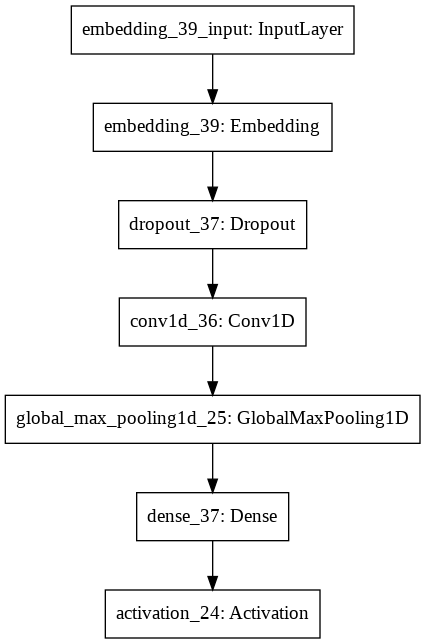

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='conv_model.png')

In [ ]:
history = model.fit(X_train, y_train, epochs = 8,  batch_size= 32, validation_data = (X_test, y_test))

Epoch 1/8
25/25 [==============================] - 1s 31ms/step - loss: 0.6274 - categorical_accuracy: 0.0000e+00 - val_loss: 0.5253 - val_categorical_accuracy: 0.0000e+00
Epoch 2/8
25/25 [==============================] - 1s 25ms/step - loss: 0.4127 - categorical_accuracy: 0.0000e+00 - val_loss: 0.3604 - val_categorical_accuracy: 0.0000e+00
Epoch 3/8
25/25 [==============================] - 1s 26ms/step - loss: 0.3528 - categorical_accuracy: 0.1125 - val_loss: 0.3507 - val_categorical_accuracy: 0.6134
Epoch 4/8
25/25 [==============================] - 1s 26ms/step - loss: 0.3465 - categorical_accuracy: 0.7490 - val_loss: 0.3488 - val_categorical_accuracy: 0.9227
Epoch 5/8
25/25 [==============================] - 1s 27ms/step - loss: 0.3447 - categorical_accuracy: 0.9599 - val_loss: 0.3471 - val_categorical_accuracy: 0.8711
Epoch 6/8
25/25 [==============================] - 1s 27ms/step - loss: 0.3426 - categorical_accuracy: 0.9082 - val_loss: 0.3453 - val_categorical_accuracy: 0.6649


**<h3>Training and Validation loss<h3>**

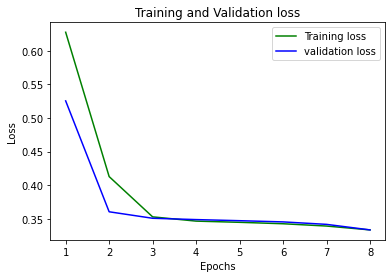

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.figure()
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**<h3>Training and Validation Accuracy for ConvNet model</h3>**

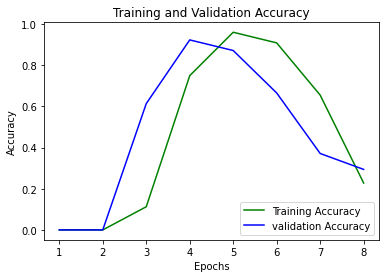

In [ ]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.figure()
epochs = range(1,len(train_acc)+1)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 6<br>
loss: 0.3434 - categorical_accuracy: 0.6611 - val_loss: 0.3467 - val_categorical_accuracy: 0.8660<br>
Epoch 7<br>
loss: 0.3405 - categorical_accuracy: 0.8771 - val_loss: 0.3421 - val_categorical_accuracy: 0.8608<br>
At the epoch 7 we have good enough validation and categorical accuracy with low loss

In [ ]:
pred = model.predict(X_test)

In [ ]:
X_test.shape

(194, 100)

In [ ]:
y_test.shape

(194, 51)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[0], pred[0]>0.5)

array([[23,  4],
       [ 5, 19]])

<h2>model-2 : LSTM<h2>

In [ ]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(max_words, output_dim=50, input_length=sequence_length))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(51, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer=Adam(lr=0.01),
            metrics=['categorical_accuracy']
)
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 100, 50)           1000000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 128)          91648     
_________________________________________________________________
dropout_38 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 51)                3315      
Total params: 1,144,371
Trainable params: 1,144,371
Non-trainable params: 0
___________________________________________

In [ ]:
callbacks_1 = [
    ReduceLROnPlateau(), 
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
]
history =  model.fit(X_train, y_train,epochs = 100, 
              batch_size= 32,validation_data = (X_test, y_test)
    )

Epoch 1/100
25/25 [==============================] - 5s 208ms/step - loss: 0.2337 - categorical_accuracy: 0.0957 - val_loss: 0.3731 - val_categorical_accuracy: 0.0412
Epoch 2/100
25/25 [==============================] - 5s 207ms/step - loss: 0.2339 - categorical_accuracy: 0.0517 - val_loss: 0.3815 - val_categorical_accuracy: 0.0052
Epoch 3/100
25/25 [==============================] - 5s 204ms/step - loss: 0.2312 - categorical_accuracy: 0.0285 - val_loss: 0.3819 - val_categorical_accuracy: 0.0412
Epoch 4/100
25/25 [==============================] - 5s 204ms/step - loss: 0.2326 - categorical_accuracy: 0.0815 - val_loss: 0.3728 - val_categorical_accuracy: 0.0722
Epoch 5/100
25/25 [==============================] - 5s 210ms/step - loss: 0.2320 - categorical_accuracy: 0.0893 - val_loss: 0.3817 - val_categorical_accuracy: 0.0567
Epoch 6/100
25/25 [==============================] - 5s 209ms/step - loss: 0.2293 - categorical_accuracy: 0.0621 - val_loss: 0.3857 - val_categorical_accuracy: 0.056

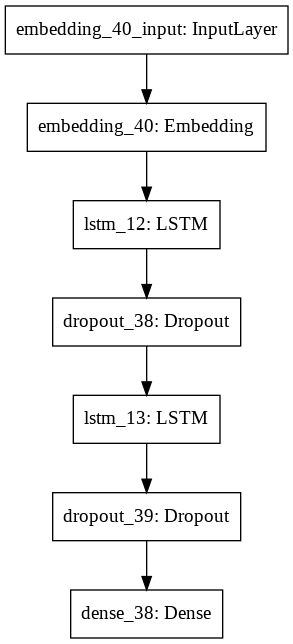

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='lstm_model.png')

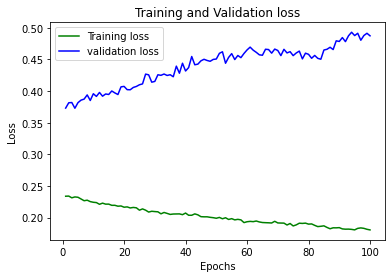

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.figure()
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

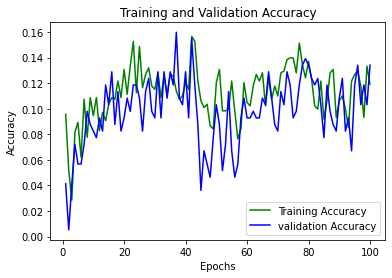

In [ ]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.figure()
epochs = range(1,len(train_acc)+1)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Note** : The second model is not optimize right now and i am still working to make it better